/var/folders/1_/dttyt12n3sb2ytwnm63wmlww0000gn/T/ipykernel_44365/3567005350.py:14: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  combined_idu = inhouse_idu.concatenate(outhouse_idu, batch_key="source", batch_categories=["inhouse", "outhouse"])
/var/folders/1_/dttyt12n3sb2ytwnm63wmlww0000gn/T/ipykernel_44365/3567005350.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  reads_per_group = combined_idu.obs.groupby('source').apply(
/var/folders/1_/dttyt12n3sb2ytwnm63wmlww0000gn/T/ipykernel_44365/3567005350.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and

DMSO correction factor: 7.292
IdU correction factor: 8.312
Untreated correction factor: 6.055


/opt/anaconda3/envs/jupyter/lib/python3.12/site-packages/scanpy/preprocessing/_normalization.py:216: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


QC Violin Plot for DMSO


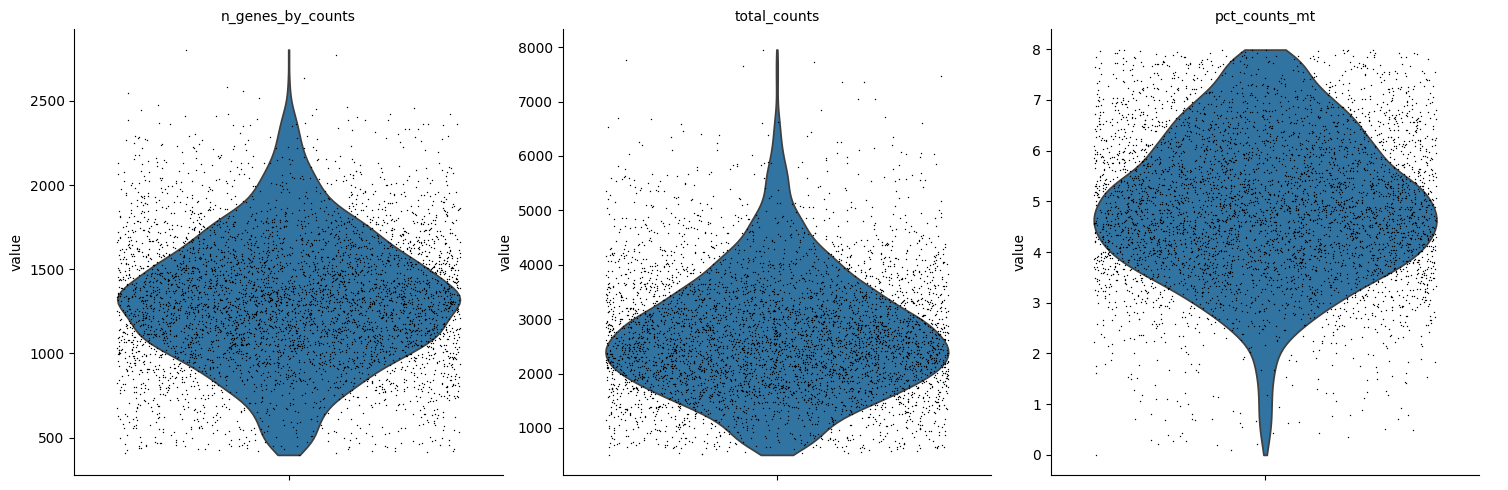

QC Violin Plot for IdU


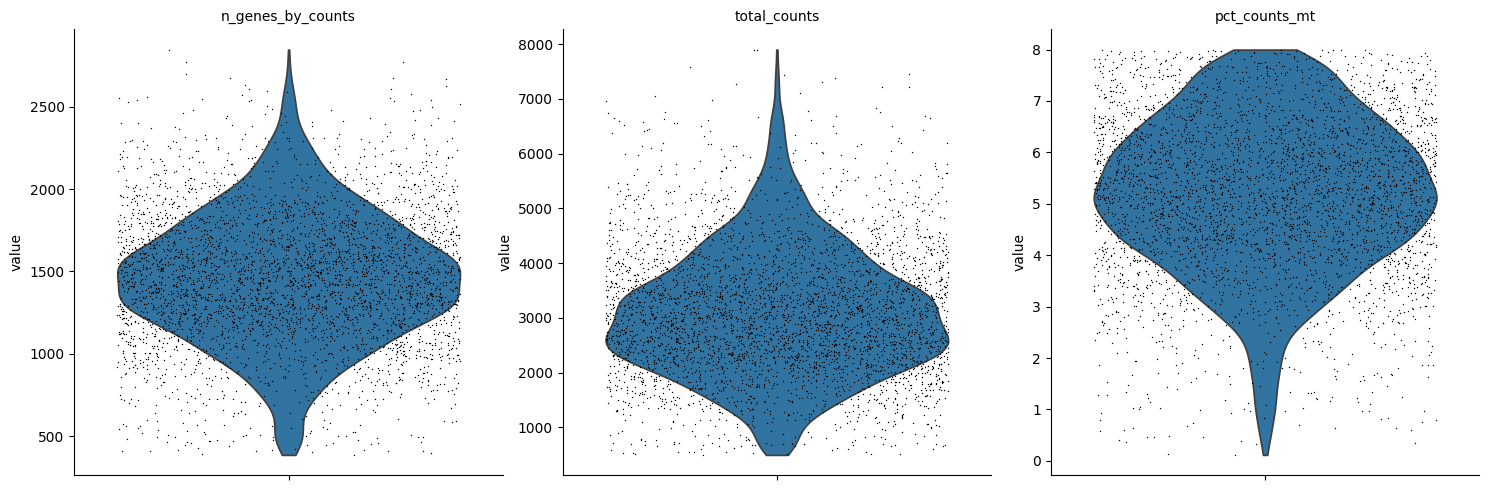

QC Violin Plot for Untreated


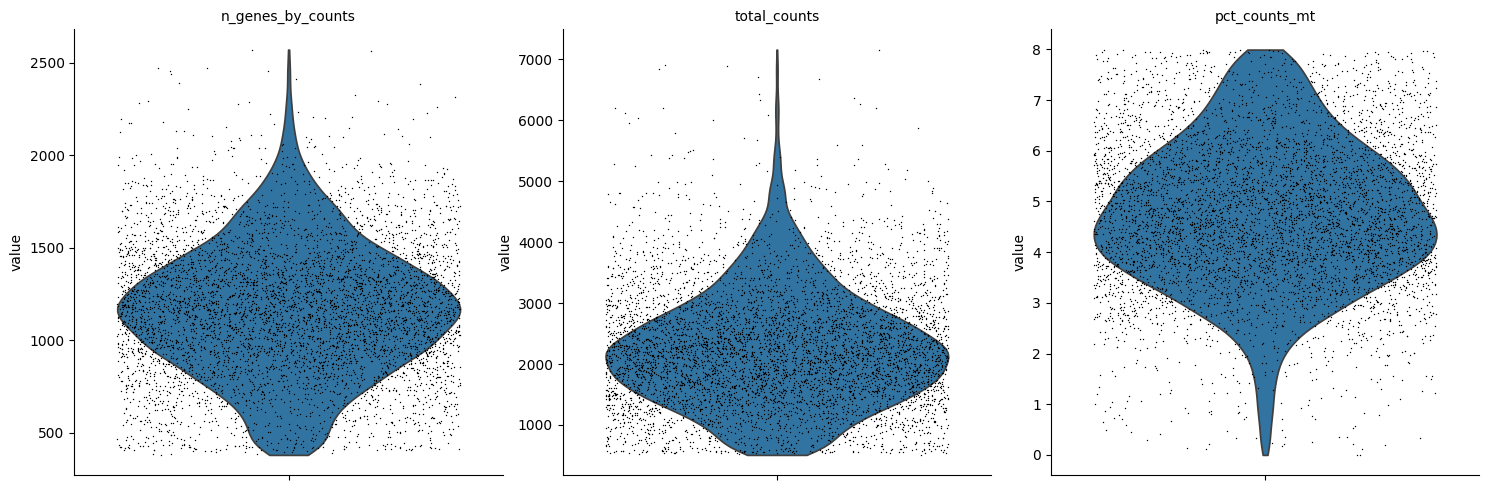

In [2]:
import scanpy as sc
import anndata as ad
import numpy as np
import pandas as pd
from scipy.sparse import issparse
import matplotlib.pyplot as plt

adata_idu = sc.read_10x_mtx("/Users/robinhrs/Stage/idu_downsampled", var_names='gene_symbols', cache=True)
adata_dmso = sc.read_10x_mtx("/Users/robinhrs/Stage/dmso_downsampled", var_names='gene_symbols', cache=True)
adata_untreated = sc.read_10x_mtx("/Users/robinhrs/Stage/untreated_yes", var_names='gene_symbols', cache=True)

def preprocess(
    adata,
    min_genes=200,
    min_cells=5,
    max_genes_by_counts=3000,
    max_total_counts=8000,
    max_pct_counts_mt=11,
    min_gene_total=10  # New argument: minimum total counts per gene
):
    #Cell-level filtering
    sc.pp.filter_cells(adata, min_genes=min_genes)
    sc.pp.filter_genes(adata, min_cells=min_cells)
    adata.var['mt'] = adata.var_names.str.startswith('mt-')
    sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
    adata = adata[adata.obs.n_genes_by_counts < max_genes_by_counts, :]
    adata = adata[adata.obs.total_counts < max_total_counts, :]
    adata = adata[adata.obs.pct_counts_mt < max_pct_counts_mt, :]

    if issparse(adata.X):
        total_counts_per_gene = np.array(adata.X.sum(axis=0)).flatten()
    else:
        total_counts_per_gene = adata.X.sum(axis=0)
    gene_mask = total_counts_per_gene >= min_gene_total
    adata = adata[:, gene_mask]

    return adata

# Filtering parameters per condition
params_by_condition = {
    'dmso': {'max_total_counts': 8000, 'max_pct_counts_mt': 8, 'max_genes_by_counts': 3000},
    'idu': {'max_total_counts': 8000, 'max_pct_counts_mt': 8, 'max_genes_by_counts': 3000},
    'untreated': {'max_total_counts': 8000, 'max_pct_counts_mt': 8, 'max_genes_by_counts': 3000},
}


# Apply preprocessing
adata_dmso = preprocess(adata_dmso, **params_by_condition['dmso'], min_gene_total=50)
adata_idu = preprocess(adata_idu, **params_by_condition['idu'], min_gene_total=50)
adata_untreated = preprocess(adata_untreated, **params_by_condition['untreated'], min_gene_total=50)


import scanpy as sc


# Allign the genes of the datasets
all_genes = set(adata_dmso.var_names) | set(adata_idu.var_names) | set(adata_untreated.var_names)

def subset_genes_safe(adata, gene_list):
    genes_in_data = [g for g in gene_list if g in adata.var_names]
    return adata[:, genes_in_data]

adata_dmso = subset_genes_safe(adata_dmso, all_genes)
adata_idu = subset_genes_safe(adata_idu, all_genes)
adata_untreated = subset_genes_safe(adata_untreated, all_genes)


# Get the means of the genes
def get_gene_means(adata):
    expr = adata.X.toarray() if hasattr(adata.X, "toarray") else adata.X
    return pd.Series(np.asarray(expr.mean(axis=0)).ravel(), index=adata.var_names)

mean_dmso = get_gene_means(adata_dmso)
mean_idu = get_gene_means(adata_idu)
mean_untreated = get_gene_means(adata_untreated)

# Combine into a single DataFrame
all_means = pd.concat([mean_dmso, mean_idu, mean_untreated], axis=1)
all_means.columns = ['dmso', 'idu', 'untreated']

# Filter genes with mean expression ≥ 0.1 in at least one condition
genes_to_keep = all_means[(all_means >= 0).any(axis=1)].index

# Subset AnnData objects
def subset_genes_to_keep(adata, genes):
    genes_in_data = [g for g in genes if g in adata.var_names]
    return adata[:, genes_in_data]

adata_dmso = subset_genes_to_keep(adata_dmso, genes_to_keep)
adata_idu = subset_genes_to_keep(adata_idu, genes_to_keep)
adata_untreated = subset_genes_to_keep(adata_untreated, genes_to_keep)

# Compute Correction Factors
def compute_corr(adata):
    if issparse(adata.X):
        umi_per_cell = np.array(adata.X.sum(axis=1)).flatten()
    else:
        umi_per_cell = np.sum(adata.X, axis=1)
    avg_umi = np.mean(umi_per_cell)
    corr = (1 / (1e4 / avg_umi)) * (10 * np.exp(1))
    return corr

dmso_corr = compute_corr(adata_dmso)
idu_corr = compute_corr(adata_idu)
untreated_corr = compute_corr(adata_untreated)

print(f"DMSO correction factor: {dmso_corr:.3f}")
print(f"IdU correction factor: {idu_corr:.3f}")
print(f"Untreated correction factor: {untreated_corr:.3f}")

# For each AnnData object
for adata in [adata_idu, adata_dmso, adata_untreated]:
    # Normalize each cell to have total counts = 10,000
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)

# Compute Statistics (original Fano formula)
def compute_stats(adata, correction_factor=1.0):
    expr = adata.X.toarray() if hasattr(adata.X, "toarray") else adata.X
    means = np.mean(expr, axis=0)
    variances = np.var(expr, ddof=1, axis=0)
    fano = (variances / means) * correction_factor 
    cv_squared = (np.sqrt(variances) / means) ** 2
    fano_nocorr = (variances / means)
    return pd.DataFrame({
        'mean': means,
        'variance': variances,
        'fano': fano,
        'cv_squared': cv_squared,
        'fano_nocorr': fano_nocorr
    }, index=adata.var_names)


stats_dmso = compute_stats(adata_dmso, correction_factor=dmso_corr)
stats_idu = compute_stats(adata_idu, correction_factor=idu_corr)
stats_untreated = compute_stats(adata_untreated, correction_factor=untreated_corr)

# QC Violin Plots without titles
for adata, label in zip([adata_dmso, adata_idu, adata_untreated], ['DMSO', 'IdU', 'Untreated']):
    print(f"QC Violin Plot for {label}")
    sc.pl.violin(
        adata,
        ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
        jitter=0.4,
        multi_panel=True,
        show=True,
    )


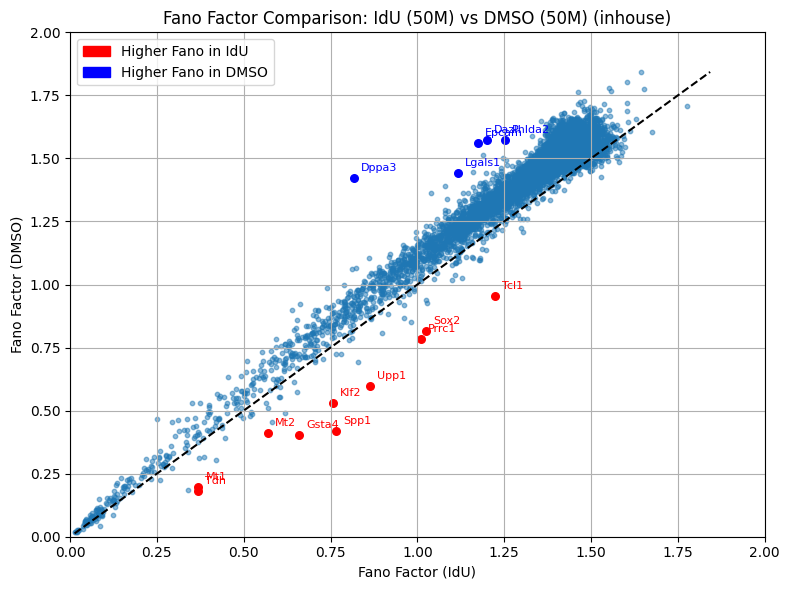

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches

common_genes = stats_idu.index.intersection(stats_dmso.index)

fano_idu = stats_idu.loc[common_genes, 'fano_nocorr']
fano_dmso = stats_dmso.loc[common_genes, 'fano_nocorr']

fano_comparison = pd.DataFrame({
    'fano_idu': fano_idu,
    'fano_dmso': fano_dmso
}).replace([np.inf, -np.inf], np.nan).dropna()

# Compute Fano difference (DMSO - Untreated)
fano_diff = fano_comparison['fano_idu'] - fano_comparison['fano_dmso']

# Top 15 genes higher in DMSO (red)
top_idu_genes = fano_diff.sort_values(ascending=False).head(10).index

# Top 5 genes higher in DMSO (blue)
top_dmso_genes = fano_diff.sort_values(ascending=True).head(5).index

# ---------- Plot ----------
plt.figure(figsize=(8, 6))
plt.scatter(fano_comparison['fano_idu'], fano_comparison['fano_dmso'],
            alpha=0.5, s=10, label='All Genes')

# Annotate top IdU-upregulated (red)
for gene in top_idu_genes:
    x = fano_comparison.loc[gene, 'fano_idu']
    y = fano_comparison.loc[gene, 'fano_dmso']
    plt.scatter(x, y, color='red', s=30)
    plt.annotate(gene, (x, y), xytext=(5, 5), textcoords='offset points',
                 fontsize=8, color='red')

# Annotate top DMSO-upregulated (blue)
for gene in top_dmso_genes:
    x = fano_comparison.loc[gene, 'fano_idu']
    y = fano_comparison.loc[gene, 'fano_dmso']
    plt.scatter(x, y, color='blue', s=30)
    plt.annotate(gene, (x, y), xytext=(5, 5), textcoords='offset points',
                 fontsize=8, color='blue')

# Identity line
min_val = min(fano_comparison.min())
max_val = max(fano_comparison.max())
plt.plot([min_val, max_val], [min_val, max_val], 'k--', label='y = x')

# Labels and title
plt.xlabel('Fano Factor (IdU)')
plt.ylabel('Fano Factor (DMSO)')
plt.title('Fano Factor Comparison: IdU (50M) vs DMSO (50M) (inhouse)')

plt.xlim(0, 2)
plt.ylim(0, 2)

# Legend
plt.legend(handles=[
    mpatches.Patch(color='red', label='Higher Fano in IdU'),
    mpatches.Patch(color='blue', label='Higher Fano in DMSO')
])

plt.grid(True)
plt.tight_layout()
plt.savefig('fano_idu_vs_dmso_annotated_final.png', dpi=300)
plt.show()


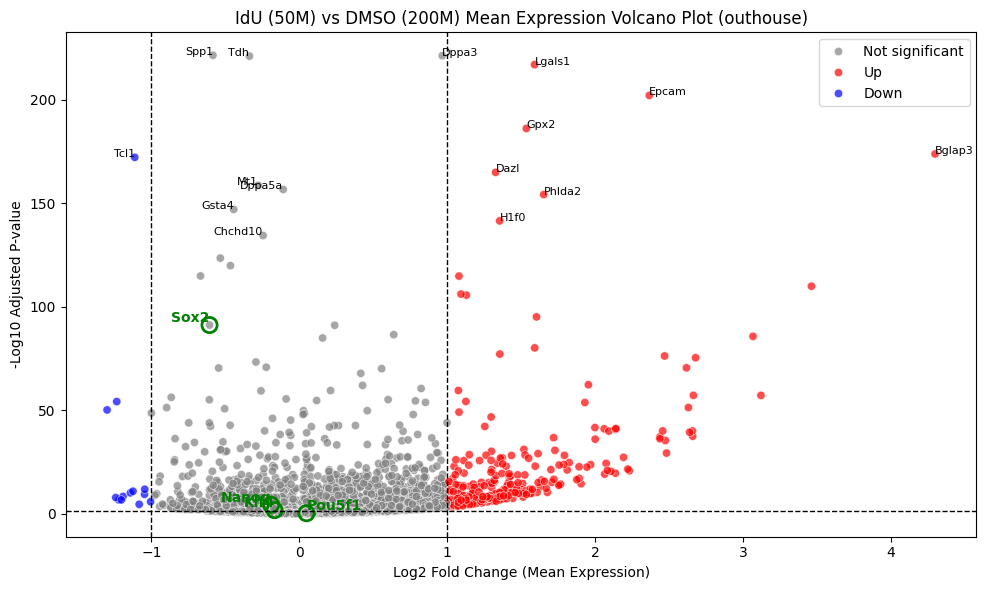

In [64]:
import numpy as np
import pandas as pd
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt
import seaborn as sns

    # 1. Extract raw expression matrices from AnnData (as before)
expr_idu = pd.DataFrame(
        adata_idu.X.toarray() if hasattr(adata_idu.X, "toarray") else adata_idu.X,
    index=adata_idu.obs_names,
    columns=adata_idu.var_names
)

expr_dmso = pd.DataFrame(
    adata_dmso.X.toarray() if hasattr(adata_idu.X, "toarray") else adata_dmso.X,
    index=adata_dmso.obs_names,
    columns=adata_dmso.var_names
)

# 2. Find common genes
genes = expr_idu.columns.intersection(expr_dmso.columns)

# 3. Compute mean expression per gene per condition
mean_idu = expr_idu[genes].mean(axis=0)
mean_dmso = expr_dmso[genes].mean(axis=0)

# 4. Compute log2 fold change of means (add small epsilon to avoid div by zero)
epsilon = 1e-6
log2_fc_mean = np.log2((mean_idu + epsilon) / (mean_dmso + epsilon))

# 5. Run t-test for difference in means per gene (same as before)
pvals = []
for gene in genes:
    try:
        stat, p = ttest_ind(expr_idu[gene], expr_dmso[gene], equal_var=False, nan_policy='omit')
        if np.isnan(p):
            p = 1.0
        pvals.append(p)
    except Exception:
        pvals.append(1.0)

# 6. Build DataFrame with results and drop NaNs
mean_df = pd.DataFrame({
    'names': genes,
    'log2_fc_mean': log2_fc_mean.reindex(genes),
    'pvals_raw': pvals
}).dropna(subset=['log2_fc_mean', 'pvals_raw']).reset_index(drop=True)

# 7. Adjust p-values with Benjamini-Hochberg
pvals_adj = multipletests(mean_df['pvals_raw'], method='fdr_bh')[1]
mean_df['pvals_adj'] = pvals_adj

# 8. Volcano plot function similar to your CV² plot style

def volcano_plot_mean(df, logfc_thresh=1, pval_thresh=0.05, title='Mean Expression Volcano Plot', top_n=10, highlight_genes=None):
    df = df.copy()
    df['log10_padj'] = -np.log10(df['pvals_adj'] + 1e-300)
    df['significance'] = 'Not significant'
    df.loc[(df['log2_fc_mean'] > logfc_thresh) & (df['pvals_adj'] < pval_thresh), 'significance'] = 'Up'
    df.loc[(df['log2_fc_mean'] < -logfc_thresh) & (df['pvals_adj'] < pval_thresh), 'significance'] = 'Down'

    top_genes = df.sort_values('pvals_adj').head(top_n)

    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df, x='log2_fc_mean', y='log10_padj', hue='significance',
                    palette={'Up': 'red', 'Down': 'blue', 'Not significant': 'grey'}, alpha=0.7)

    plt.axhline(-np.log10(pval_thresh), color='black', linestyle='--', linewidth=1)
    plt.axvline(logfc_thresh, color='black', linestyle='--', linewidth=1)
    plt.axvline(-logfc_thresh, color='black', linestyle='--', linewidth=1)

    # Label top genes by adjusted p-value
    for _, row in top_genes.iterrows():
        plt.text(row['log2_fc_mean'], row['log10_padj'], row['names'],
                 fontsize=8, ha='right' if row['log2_fc_mean'] < 0 else 'left')

    # Highlight specific genes (e.g., pluripotency markers)
    if highlight_genes:
        highlight_genes_lower = [g.lower() for g in highlight_genes]
        highlighted = df[df['names'].str.lower().isin(highlight_genes_lower)]
        for _, row in highlighted.iterrows():
            plt.scatter(row['log2_fc_mean'], row['log10_padj'], s=120, facecolors='none',
                        edgecolors='green', linewidths=2)
            plt.text(row['log2_fc_mean'], row['log10_padj'], row['names'],
                     fontsize=10, fontweight='bold', color='green',
                     ha='right' if row['log2_fc_mean'] < 0 else 'left', va='bottom')

    plt.xlabel('Log2 Fold Change (Mean Expression)')
    plt.ylabel('-Log10 Adjusted P-value')
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.savefig('mean_volcano.png', dpi=300)

    plt.show()


# Example usage:
highlight_genes_list = ['Sox2', 'Nanog', 'Klf4', 'Pou5f1']

volcano_plot_mean(mean_df,
                  logfc_thresh=1,
                  pval_thresh=0.05,
                  title="IdU (50M) vs DMSO (200M) Mean Expression Volcano Plot (outhouse)",
                  top_n=15,
                  highlight_genes=highlight_genes_list)


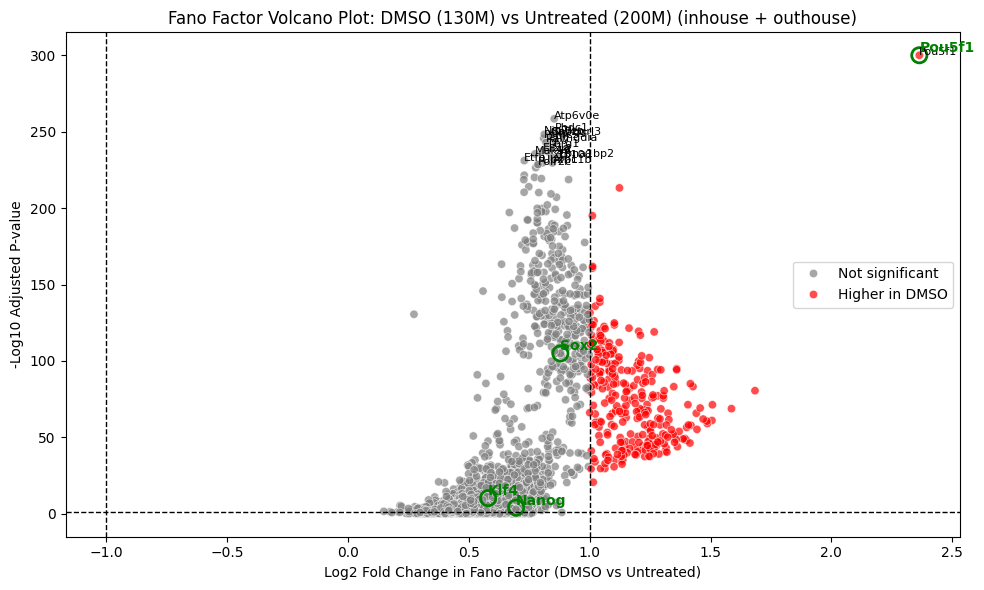

In [525]:
import numpy as np
import pandas as pd
from scipy.stats import levene
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt
import seaborn as sns

# Assume you already have these:
# - adata_idu, adata_dmso: AnnData objects with raw expression data
# - stats_idu, stats_dmso: dicts or DataFrames with precomputed 'fano' factor Series indexed by genes

# 1. Calculate log2 fold change of Fano factor (DMSO vs DMSO)
fano_dmso = stats_dmso['fano_nocorr']  # pandas Series indexed by genes
fano_untreated = stats_untreated['fano_nocorr']  # pandas Series indexed by genes

log2_fc_fano = np.log2(fano_dmso / fano_untreated).replace([np.inf, -np.inf], np.nan)

# 2. Extract raw expression matrices as pandas DataFrames
expr_dmso = pd.DataFrame(
    adata_dmso.X.toarray() if hasattr(adata_dmso.X, "toarray") else adata_dmso.X,
    index=adata_dmso.obs_names,
    columns=adata_dmso.var_names
)

expr_untreated = pd.DataFrame(
    adata_untreated.X.toarray() if hasattr(adata_untreated.X, "toarray") else adata_untreated.X,
    index=adata_untreated.obs_names,
    columns=adata_untreated.var_names
)

# 3. Find genes common to both datasets
genes = expr_dmso.columns.intersection(expr_untreated.columns)

# 4. Perform Levene's test for variance equality per gene (on raw expression)
pvals = []
for gene in genes:
    try:
        stat, p = levene(expr_dmso[gene], expr_untreated[gene])
        if np.isnan(p):
            p = 1.0
        pvals.append(p)
    except Exception:
        pvals.append(1.0)  # default p-value if error

# 5. Build DataFrame with gene names, log2 fold change of Fano, and raw p-values
fano_df = pd.DataFrame({
    'names': genes,
    'log2_fc_fano': log2_fc_fano.reindex(genes),
    'pvals_raw': pvals
}).dropna(subset=['log2_fc_fano', 'pvals_raw']).reset_index(drop=True)

# 6. Adjust p-values with Benjamini-Hochberg correction (FDR)
pvals_adj = multipletests(fano_df['pvals_raw'], method='fdr_bh')[1]
fano_df['pvals_adj'] = pvals_adj

# 7. Define the volcano plot function (with gene highlighting)
def volcano_plot_fano(df, logfc_thresh=1, pval_thresh=0.05, title='Volcano Plot of Fano Differences', top_n=20, highlight_genes=None):
    df = df.copy()
    df['log10_padj'] = -np.log10(df['pvals_adj'] + 1e-300)
    df['significance'] = 'Not significant'
    df.loc[(df['log2_fc_fano'] > logfc_thresh) & (df['pvals_adj'] < pval_thresh), 'significance'] = 'Higher in DMSO'
    df.loc[(df['log2_fc_fano'] < -logfc_thresh) & (df['pvals_adj'] < pval_thresh), 'significance'] = 'Higher in Untreated'

    top_genes = df.sort_values('pvals_adj').head(top_n)

    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df, x='log2_fc_fano', y='log10_padj', hue='significance',
                    palette={'Higher in DMSO': 'red', 'Higher in Untreated': 'blue', 'Not significant': 'grey'}, alpha=0.7)

    plt.axhline(-np.log10(pval_thresh), color='black', linestyle='--', linewidth=1)
    plt.axvline(logfc_thresh, color='black', linestyle='--', linewidth=1)
    plt.axvline(-logfc_thresh, color='black', linestyle='--', linewidth=1)

    # Label top genes by p-value
    for _, row in top_genes.iterrows():
        plt.text(row['log2_fc_fano'], row['log10_padj'], row['names'],
                 fontsize=8, ha='right' if row['log2_fc_fano'] < 0 else 'left')

    # Highlight specific genes if provided
    if highlight_genes:
        highlight_genes_lower = [g.lower() for g in highlight_genes]
        highlighted = df[df['names'].str.lower().isin(highlight_genes_lower)]
        for _, row in highlighted.iterrows():
            plt.scatter(row['log2_fc_fano'], row['log10_padj'], s=120, facecolors='none',
                        edgecolors='green', linewidths=2)
            plt.text(row['log2_fc_fano'], row['log10_padj'], row['names'],
                     fontsize=10, fontweight='bold', color='green',
                     ha='right' if row['log2_fc_fano'] < 0 else 'left', va='bottom')

    plt.xlabel('Log2 Fold Change in Fano Factor (DMSO vs Untreated)')
    plt.ylabel('-Log10 Adjusted P-value')
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.savefig('fano_volcano_plot.png', dpi=300)
    plt.show()

# 8. Call the plot with genes you want to highlight
highlight_genes_list = ['Sox2', 'Nanog', 'Klf4', 'Pou5f1']  # example pluripotency markers

volcano_plot_fano(fano_df,
                 logfc_thresh=1,
                 pval_thresh=0.05,
                 title="Fano Factor Volcano Plot: DMSO (50M) vs Untreated (50M) (inhouse + outhouse)",
                 top_n=20,
                 highlight_genes=highlight_genes_list)


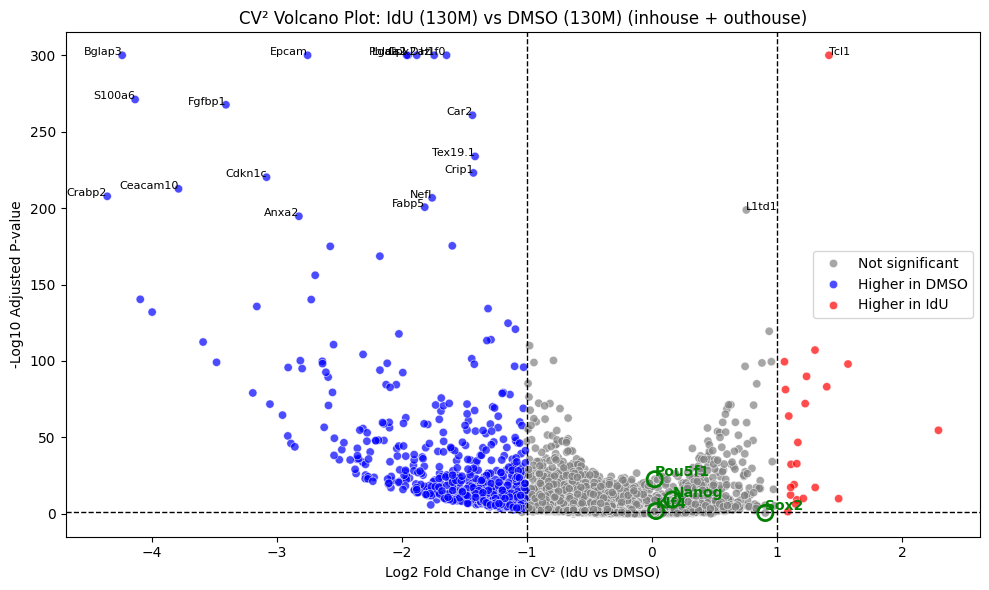

In [553]:
import numpy as np
import pandas as pd
from scipy.stats import levene
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Calculate log2 fold change of CV² (IdU vs DMSO)
cv2_idu = stats_idu['cv_squared']  # pandas Series indexed by genes
cv2_untreated = stats_untreated['cv_squared']  # pandas Series indexed by genes

# 2. Extract raw expression matrices as pandas DataFrames
expr_idu = pd.DataFrame(
    adata_idu.X.toarray() if hasattr(adata_idu.X, "toarray") else adata_idu.X,
    index=adata_idu.obs_names,
    columns=adata_idu.var_names
)

expr_untreated = pd.DataFrame(
    adata_untreated.X.toarray() if hasattr(adata_untreated.X, "toarray") else adata_untreated.X,
    index=adata_untreated.obs_names,
    columns=adata_untreated.var_names
)


log2_fc_cv2 = np.log2(cv2_idu / cv2_untreated).replace([np.inf, -np.inf], np.nan)

# 2. Use the same expression matrices
# expr_idu and expr_dmso already exist from earlier

# 3. Find common genes
genes_cv2 = expr_idu.columns.intersection(expr_untreated.columns)

# 4. Levene’s test per gene
pvals_cv2 = []
for gene in genes_cv2:
    try:
        stat, p = levene(expr_idu[gene], expr_untreated[gene])
        if np.isnan(p):
            p = 1.0
        pvals_cv2.append(p)
    except Exception:
        pvals_cv2.append(1.0)

# 5. Build CV² DataFrame
cv2_df = pd.DataFrame({
    'names': genes_cv2,
    'log2_fc_cv2': log2_fc_cv2.reindex(genes_cv2),
    'pvals_raw': pvals_cv2
}).dropna(subset=['log2_fc_cv2', 'pvals_raw']).reset_index(drop=True)

# 6. Adjust p-values
pvals_adj_cv2 = multipletests(cv2_df['pvals_raw'], method='fdr_bh')[1]
cv2_df['pvals_adj'] = pvals_adj_cv2

# 7. Volcano plot for CV²
def volcano_plot_cv2(df, logfc_thresh=1, pval_thresh=0.05, title='Volcano Plot of CV² Differences', top_n=20, highlight_genes=None):
    df = df.copy()
    df['log10_padj'] = -np.log10(df['pvals_adj'] + 1e-300)
    df['significance'] = 'Not significant'
    df.loc[(df['log2_fc_cv2'] > logfc_thresh) & (df['pvals_adj'] < pval_thresh), 'significance'] = 'Higher in IdU'
    df.loc[(df['log2_fc_cv2'] < -logfc_thresh) & (df['pvals_adj'] < pval_thresh), 'significance'] = 'Higher in Untreated'

    top_genes = df.sort_values('pvals_adj').head(top_n)

    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df, x='log2_fc_cv2', y='log10_padj', hue='significance',
                    palette={'Higher in IdU': 'red', 'Higher in Untreated': 'blue', 'Not significant': 'grey'}, alpha=0.7)

    plt.axhline(-np.log10(pval_thresh), color='black', linestyle='--', linewidth=1)
    plt.axvline(logfc_thresh, color='black', linestyle='--', linewidth=1)
    plt.axvline(-logfc_thresh, color='black', linestyle='--', linewidth=1)

    # Label top genes
    for _, row in top_genes.iterrows():
        plt.text(row['log2_fc_cv2'], row['log10_padj'], row['names'],
                 fontsize=8, ha='right' if row['log2_fc_cv2'] < 0 else 'left')

    # Highlight specific genes if needed
    if highlight_genes:
        highlight_genes_lower = [g.lower() for g in highlight_genes]
        highlighted = df[df['names'].str.lower().isin(highlight_genes_lower)]
        for _, row in highlighted.iterrows():
            plt.scatter(row['log2_fc_cv2'], row['log10_padj'], s=120, facecolors='none',
                        edgecolors='green', linewidths=2)
            plt.text(row['log2_fc_cv2'], row['log10_padj'], row['names'],
                     fontsize=10, fontweight='bold', color='green',
                     ha='right' if row['log2_fc_cv2'] < 0 else 'left', va='bottom')

    plt.xlabel('Log2 Fold Change in CV² (IdU vs Untreated)')
    plt.ylabel('-Log10 Adjusted P-value')
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.savefig('cv2_volcano_plot.png', dpi=300)
    plt.show()

# 8. Call the plot
highlight_genes_list = ['Sox2', 'Nanog', 'Klf4', 'Pou5f1']  # optional

volcano_plot_cv2(cv2_df,
                 logfc_thresh=1,
                 pval_thresh=0.05,
                 title="CV² Volcano Plot: IdU (70M) vs Untreated (50M) (inhouse)",
                 top_n=20,
                 highlight_genes=highlight_genes_list)


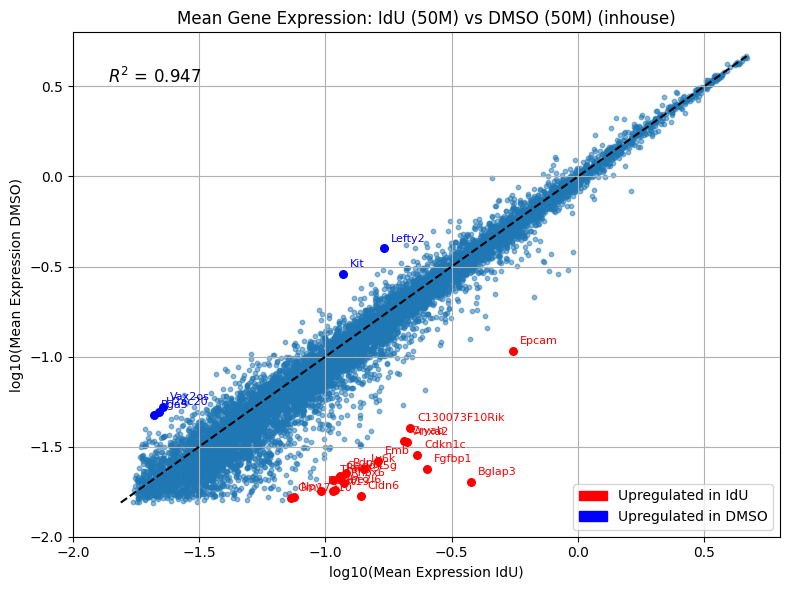

In [62]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches
from sklearn.metrics import r2_score

# Get common genes
common_genes = stats_idu.index.intersection(stats_dmso.index)
stats_idu_common = stats_idu.loc[common_genes]
stats_dmso_common = stats_dmso.loc[common_genes]

# Compute log10 mean expressions
log_idu = np.log10(stats_idu_common['mean'] + 1e-3)
log_dmso = np.log10(stats_dmso_common['mean'] + 1e-3)

# Compute log fold change (DMSO vs Untreated)
log_fc = log_idu - log_dmso

# Get top 10 upregulated in IdU
top_idu_genes = log_fc.sort_values(ascending=False).head(20).index

# Get top 5 upregulated in Untreated
top_dmso_genes = log_fc.sort_values(ascending=True).head(5).index

# Compute R²
r2 = r2_score(log_dmso, log_idu)

# Plot base layer
plt.figure(figsize=(8, 6))
plt.scatter(log_idu, log_dmso, alpha=0.5, label='All Genes', s=10)

# Highlight and annotate IdU upregulated
for gene in top_idu_genes:
    x, y = log_idu[gene], log_dmso[gene]
    plt.scatter(x, y, color='red', s=30, zorder=3)
    plt.annotate(gene, (x, y), xytext=(5, 5), textcoords='offset points',
                 fontsize=8, color='red', zorder=4)

# Highlight and annotate Untreated upregulated
for gene in top_dmso_genes:
    x, y = log_idu[gene], log_dmso[gene]
    plt.scatter(x, y, color='blue', s=30, zorder=3)
    plt.annotate(gene, (x, y), xytext=(5, 5), textcoords='offset points',
                 fontsize=8, color='blue', zorder=4)

# Add y = x line
lims = [min(log_idu.min(), log_dmso.min()), max(log_idu.max(), log_dmso.max())]
plt.plot(lims, lims, 'k--', label='y = x')

# Add R² text inside the plot
plt.text(0.05, 0.9, f'$R^2$ = {r2:.3f}', transform=plt.gca().transAxes, fontsize=12)

# Labels and limits
plt.xlabel('log10(Mean Expression IdU)')
plt.ylabel('log10(Mean Expression DMSO)')
plt.xlim(-2, 0.8)
plt.ylim(-2, 0.8)
plt.title('Mean Gene Expression: IdU (50M) vs DMSO (50M) (inhouse)')

# Custom legend
red_patch = mpatches.Patch(color='red', label='Upregulated in IdU')
blue_patch = mpatches.Patch(color='blue', label='Upregulated in DMSO')
plt.legend(handles=[red_patch, blue_patch])

# Final touches
plt.grid(True)
plt.tight_layout()
plt.savefig('dmsountreated_annotated.png', dpi=300)
plt.show()


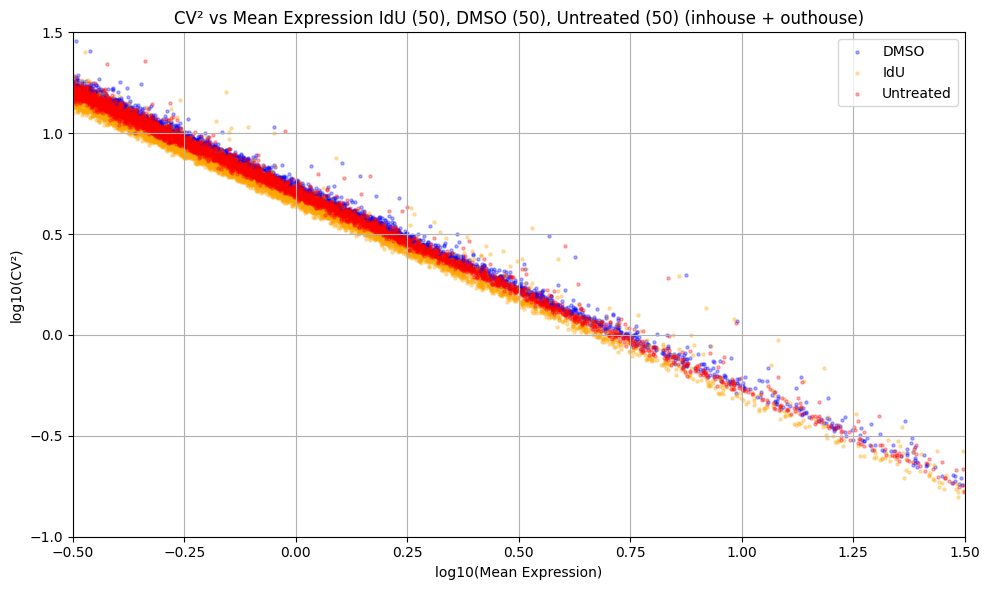

In [72]:
import numpy as np
import matplotlib.pyplot as plt

# Extract values for plotting (all genes)
mean_dmso = stats_dmso['mean']
cv2_dmso = stats_dmso['cv_squared']

mean_idu = stats_idu['mean']
cv2_idu = stats_idu['cv_squared']

mean_untreated = stats_untreated['mean']
cv2_untreated = stats_untreated['cv_squared']

# Avoid log(0) by adding a small offset
offset = 1e-3

plt.figure(figsize=(10, 6))
plt.scatter(np.log10(mean_dmso + offset), np.log10(cv2_dmso + offset), 
            alpha=0.3, s=5, label='DMSO', color='blue')
plt.scatter(np.log10(mean_idu + offset), np.log10(cv2_idu + offset), 
            alpha=0.3, s=5, label='IdU', color='orange')
plt.scatter(np.log10(mean_untreated + offset), np.log10(cv2_untreated + offset), 
            alpha=0.3, s=5, label='Untreated', color='red')

plt.xlabel('log10(Mean Expression)')
plt.ylabel('log10(CV²)')
plt.title('CV² vs Mean Expression IdU (50), DMSO (50), Untreated (50) (inhouse + outhouse)')
plt.legend()
plt.grid(True)
plt.xlim(-0.5, 1.5) 
plt.ylim(-1, 1.5)# Adjust x-axis range based on the data
plt.tight_layout()
plt.savefig('cv2_vs_mean_all_genes.png', dpi=300)
plt.show()


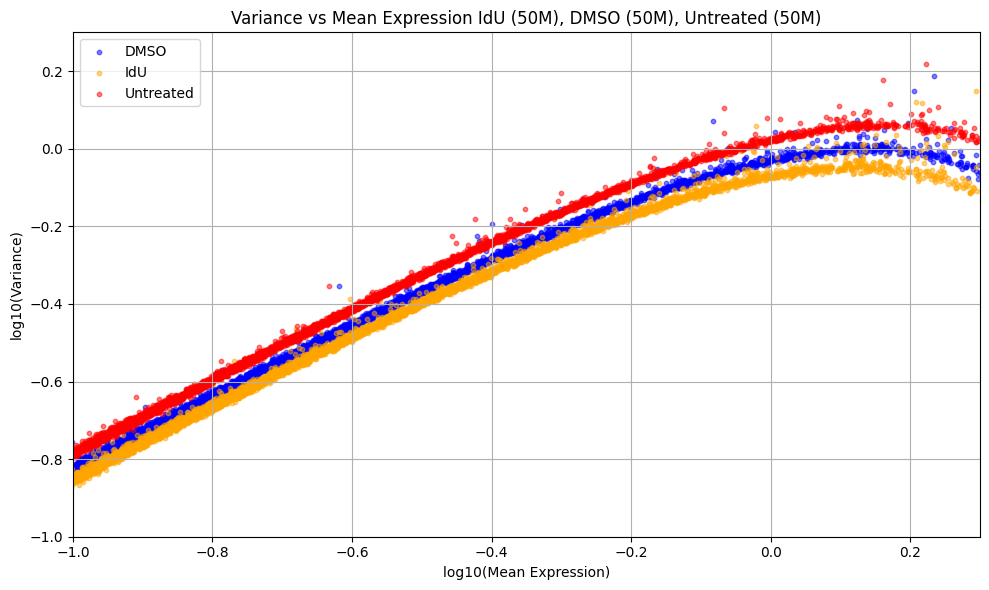

In [84]:
import numpy as np
import matplotlib.pyplot as plt

# Extract values for plotting (all genes)
mean_dmso = stats_dmso['mean']
var_dmso = stats_dmso['variance']

mean_idu = stats_idu['mean']
var_idu = stats_idu['variance']

mean_untreated = stats_untreated['mean']
var_untreated = stats_untreated['variance']

# Avoid log(0) by adding a small offset
offset = 1e-3

plt.figure(figsize=(10, 6))
plt.scatter(np.log10(mean_dmso + offset), np.log10(var_dmso + offset), 
            alpha=0.5, s=10, label='DMSO', color='blue')
plt.scatter(np.log10(mean_idu + offset), np.log10(var_idu + offset), 
            alpha=0.5, s=10, label='IdU', color='orange')
plt.scatter(np.log10(mean_untreated + offset), np.log10(var_untreated + offset), 
            alpha=0.5, s=10, label='Untreated', color='red')


plt.xlabel('log10(Mean Expression)')
plt.ylabel('log10(Variance)')
plt.title('Variance vs Mean Expression IdU (50M), DMSO (50M), Untreated (50M)')
plt.legend()
plt.grid(True)
plt.xlim(-1, 0.3)    # Adjust x-axis range as needed
plt.ylim(-1, 0.3)    # Adjust y-axis range as needed
plt.tight_layout()
plt.savefig('variance_vs_mean_all_genes.png', dpi=300)
plt.show()


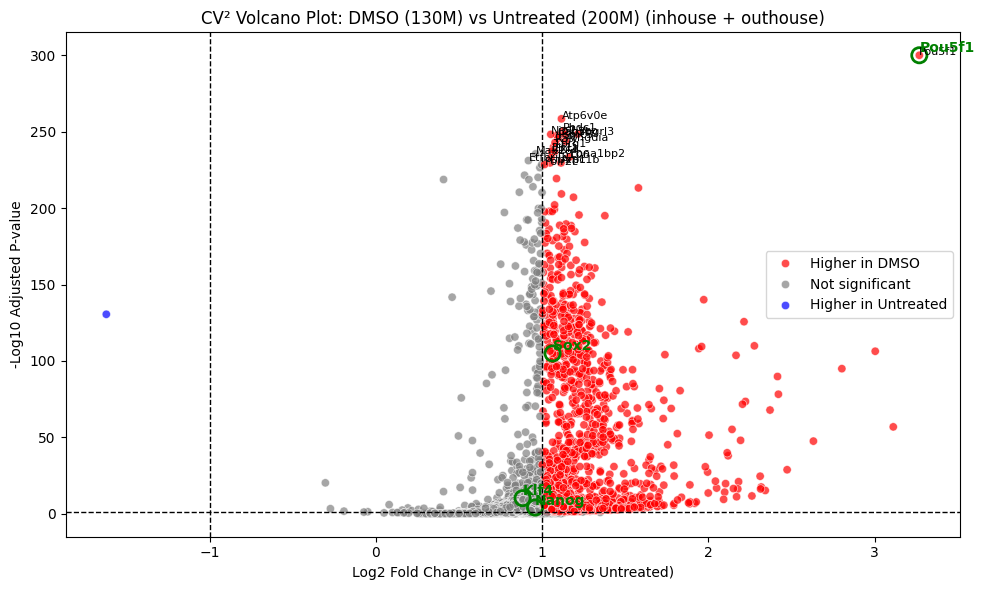

In [607]:
import numpy as np
import pandas as pd
from scipy.stats import levene
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt
import seaborn as sns

# Assume you already have these:
# - adata_idu, adata_untreated: AnnData objects with raw expression data
# - stats_idu, stats_dmso: dicts or DataFrames with precomputed 'cv2' Series indexed by genes

# 1. Calculate log2 fold change of CV² (IdU vs DMSO)
cv2_dmso = stats_dmso['cv_squared']  # pandas Series indexed by genes
cv2_untreated = stats_untreated['cv_squared']  # pandas Series indexed by genes

log2_fc_cv2 = np.log2(cv2_dmso / cv2_untreated).replace([np.inf, -np.inf], np.nan)

# 2. Extract raw expression matrices as pandas DataFrames
expr_dmso = pd.DataFrame(
    adata_dmso.X.toarray() if hasattr(adata_dmso.X, "toarray") else adata_dmso.X,
    index=adata_dmso.obs_names,
    columns=adata_dmso.var_names
)

expr_untreated = pd.DataFrame(
    adata_untreated.X.toarray() if hasattr(adata_untreated.X, "toarray") else adata_untreated.X,
    index=adata_untreated.obs_names,
    columns=adata_untreated.var_names
)

# 3. Find genes common to both datasets
genes = expr_dmso.columns.intersection(expr_untreated.columns)

# 4. Perform Levene's test for variance equality per gene (on raw expression)
pvals = []
for gene in genes:
    try:
        stat, p = levene(expr_dmso[gene], expr_untreated[gene])
        if np.isnan(p):
            p = 1.0
        pvals.append(p)
    except Exception:
        pvals.append(1.0)

# 5. Build DataFrame with gene names, log2 fold change of CV², and raw p-values
cv2_df = pd.DataFrame({
    'names': genes,
    'log2_fc_cv2': log2_fc_cv2.reindex(genes),
    'pvals_raw': pvals
}).dropna(subset=['log2_fc_cv2', 'pvals_raw']).reset_index(drop=True)

# 6. Adjust p-values with Benjamini-Hochberg correction
pvals_adj = multipletests(cv2_df['pvals_raw'], method='fdr_bh')[1]
cv2_df['pvals_adj'] = pvals_adj

# 7. Volcano plot function for CV²
def volcano_plot_cv2(df, logfc_thresh=1, pval_thresh=0.05, title='Volcano Plot of CV² Differences', top_n=20, highlight_genes=None):
    df = df.copy()
    df['log10_padj'] = -np.log10(df['pvals_adj'] + 1e-300)
    df['significance'] = 'Not significant'
    df.loc[(df['log2_fc_cv2'] > logfc_thresh) & (df['pvals_adj'] < pval_thresh), 'significance'] = 'Higher in DMSO'
    df.loc[(df['log2_fc_cv2'] < -logfc_thresh) & (df['pvals_adj'] < pval_thresh), 'significance'] = 'Higher in Untreated'

    top_genes = df.sort_values('pvals_adj').head(top_n)

    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df, x='log2_fc_cv2', y='log10_padj', hue='significance',
                    palette={'Higher in DMSO': 'red', 'Higher in Untreated': 'blue', 'Not significant': 'grey'}, alpha=0.7)

    plt.axhline(-np.log10(pval_thresh), color='black', linestyle='--', linewidth=1)
    plt.axvline(logfc_thresh, color='black', linestyle='--', linewidth=1)
    plt.axvline(-logfc_thresh, color='black', linestyle='--', linewidth=1)

    # Label top genes by p-value
    for _, row in top_genes.iterrows():
        plt.text(row['log2_fc_cv2'], row['log10_padj'], row['names'],
                 fontsize=8, ha='right' if row['log2_fc_cv2'] < 0 else 'left')

    # Highlight specific genes if provided
    if highlight_genes:
        highlight_genes_lower = [g.lower() for g in highlight_genes]
        highlighted = df[df['names'].str.lower().isin(highlight_genes_lower)]
        for _, row in highlighted.iterrows():
            plt.scatter(row['log2_fc_cv2'], row['log10_padj'], s=120, facecolors='none',
                        edgecolors='green', linewidths=2)
            plt.text(row['log2_fc_cv2'], row['log10_padj'], row['names'],
                     fontsize=10, fontweight='bold', color='green',
                     ha='right' if row['log2_fc_cv2'] < 0 else 'left', va='bottom')

    plt.xlabel('Log2 Fold Change in CV² (DMSO vs Untreated)')
    plt.ylabel('-Log10 Adjusted P-value')
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.savefig('cv2_volcano_plot.png', dpi=300)
    plt.show()

# 8. Call the CV² volcano plot
highlight_genes_list = ['Sox2', 'Nanog', 'Klf4', 'Pou5f1']

volcano_plot_cv2(cv2_df,
                 logfc_thresh=1,
                 pval_thresh=0.05,
                 title="CV² Volcano Plot: DMSO (130M) vs Untreated (200M) (inhouse + outhouse)",
                 top_n=20,
                 highlight_genes=highlight_genes_list)


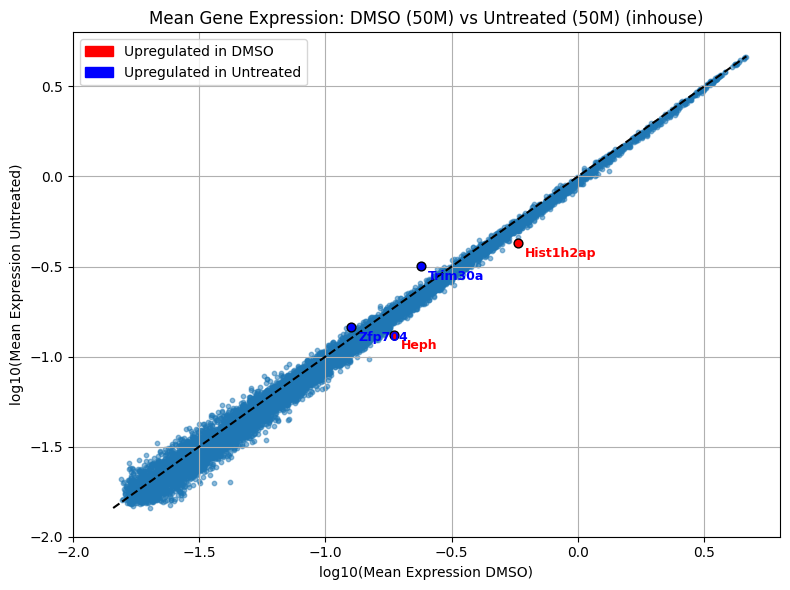

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches

# Get common genes
common_genes = stats_dmso.index.intersection(stats_untreated.index)
stats_dmso_common = stats_dmso.loc[common_genes]
stats_untreated_common = stats_untreated.loc[common_genes]

# Compute log10 mean expressions
log_dmso = np.log10(stats_dmso_common['mean'] + 1e-3)
log_untreated = np.log10(stats_untreated_common['mean'] + 1e-3)

# Compute log fold change (DMSO vs Untreated)
log_fc = log_dmso - log_untreated

# Plot base layer
plt.figure(figsize=(8, 6))
plt.scatter(log_dmso, log_untreated, alpha=0.5, label='All Genes', s=10)

# Highlight and annotate specific genes of interest
highlight_genes = ['Hist1h2ap', 'Heph', 'Trim30a', 'Zfp704']
for gene in highlight_genes:
    if gene in log_fc.index:
        x, y = log_dmso[gene], log_untreated[gene]
        fc = log_fc[gene]

        # Red = up in DMSO; Blue = up in Untreated
        if fc > 0:
            color = 'red'
        else:
            color = 'blue'

        plt.scatter(x, y, color=color, s=40, edgecolor='black', zorder=5)
        plt.annotate(gene, (x, y), xytext=(5, -10), textcoords='offset points',
                     fontsize=9, color=color, fontweight='bold', zorder=6)

# Add y = x line
lims = [min(log_dmso.min(), log_untreated.min()), max(log_dmso.max(), log_untreated.max())]
plt.plot(lims, lims, 'k--', label='y = x')

# Labels and limits
plt.xlabel('log10(Mean Expression DMSO)')
plt.ylabel('log10(Mean Expression Untreated)')
plt.xlim(-2, 0.8)
plt.ylim(-2, 0.8)
plt.title('Mean Gene Expression: DMSO (50M) vs Untreated (50M) (inhouse)')

# Custom legend
red_patch = mpatches.Patch(color='red', label='Upregulated in DMSO')
blue_patch = mpatches.Patch(color='blue', label='Upregulated in Untreated')
plt.legend(handles=[red_patch, blue_patch])

# Final touches
plt.grid(True)
plt.tight_layout()
plt.savefig('dmsountreated_annotated.png', dpi=300)
plt.show()


R² = 0.9340


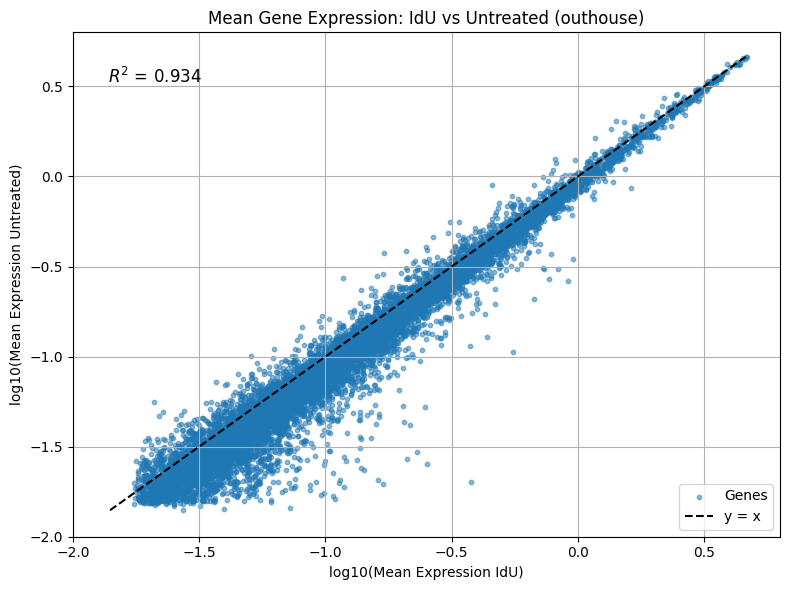

In [54]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import ttest_rel
from sklearn.metrics import r2_score

# Get common genes
common_genes = stats_idu.index.intersection(stats_untreated.index)
stats_idu_common = stats_idu.loc[common_genes]
stats_untreated_common = stats_untreated.loc[common_genes]

# Compute log10 mean expressions
log_idu = np.log10(stats_idu_common['mean'] + 1e-3)
log_untreated = np.log10(stats_untreated_common['mean'] + 1e-3)

# Compute R²
r2 = r2_score(log_untreated, log_idu)
print(f"R² = {r2:.4f}")

# Plot base layer
plt.figure(figsize=(8, 6))
plt.scatter(log_idu, log_untreated, alpha=0.5, s=10, label='Genes')  # Scatter with label

# Add y = x line with label for legend
lims = [min(log_idu.min(), log_untreated.min()), max(log_idu.max(), log_untreated.max())]
plt.plot(lims, lims, 'k--', label='y = x')

# Add R² text inside the plot
plt.text(0.05, 0.9, f'$R^2$ = {r2:.3f}', transform=plt.gca().transAxes, fontsize=12)

# Labels and limits
plt.xlabel('log10(Mean Expression IdU)')
plt.ylabel('log10(Mean Expression Untreated)')
plt.xlim(-2, 0.8)
plt.ylim(-2, 0.8)
plt.title('Mean Gene Expression: IdU vs Untreated (outhouse)')

# Show legend
plt.legend()

# Final touches
plt.grid(True)
plt.tight_layout()
plt.savefig('dmsountreated_clean.png', dpi=300)
plt.show()


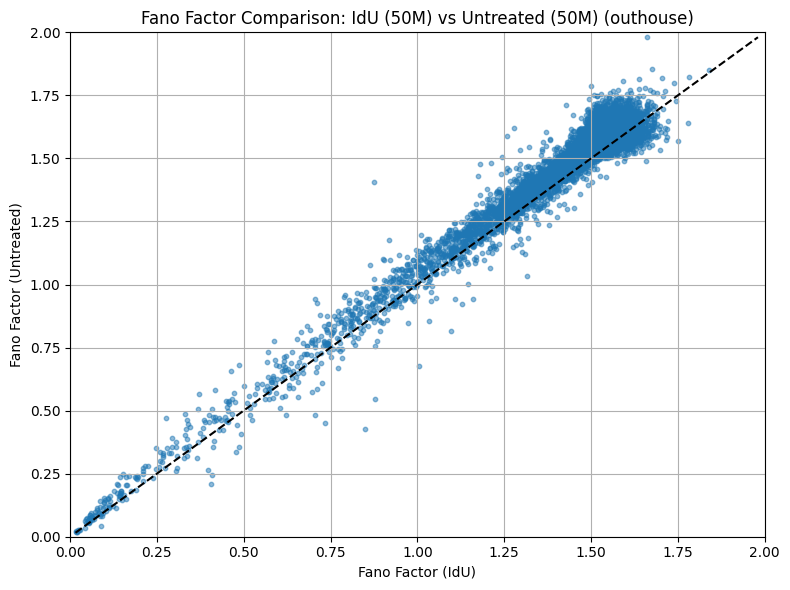

In [21]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches
import pandas as pd  # Ensure this is imported

# ---------- Compare IdU vs DMSO Fano Factors ----------
common_genes = stats_idu.index.intersection(stats_untreated.index)

fano_idu = stats_idu.loc[common_genes, 'fano_nocorr']
fano_untreated = stats_untreated.loc[common_genes, 'fano_nocorr']

fano_comparison = pd.DataFrame({
    'fano_idu': fano_idu,
    'fano_untreated': fano_untreated
}).replace([np.inf, -np.inf], np.nan).dropna()

# ---------- Plot ----------
plt.figure(figsize=(6, 6))
plt.scatter(fano_comparison['fano_idu'], fano_comparison['fano_untreated'],
            alpha=0.5, s=10, label='All Genes')

# Identity line (now red)
min_val = min(fano_comparison.min())
max_val = max(fano_comparison.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='y = x')

# Labels and title
plt.xlabel('Fano Factor (IdU)')
plt.ylabel('Fano Factor (Untreated)')
plt.title('Fano Factor Comparison: IdU (60M) vs Untreated (200M) (outhouse)')

plt.xlim(0, 2)
plt.ylim(0, 2)
plt.gca().set_aspect('equal')

plt.grid(True)
plt.tight_layout()
plt.savefig('fano_idu_vs_dmso_square_redline.png', dpi=300)
plt.show()


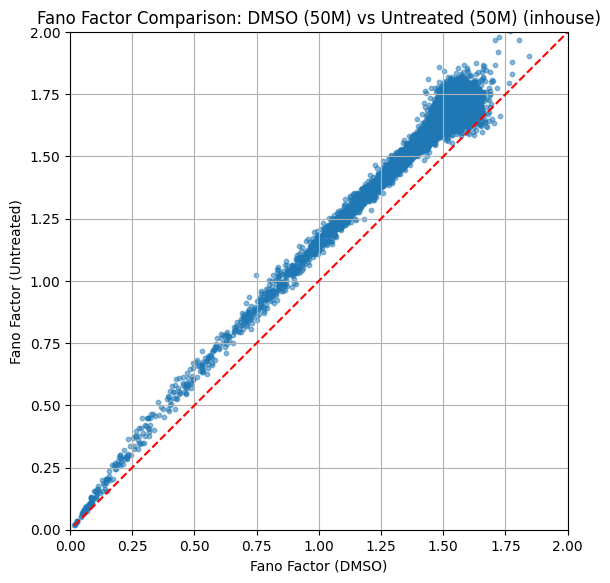

In [37]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd  # Make sure pandas is imported

# ---------- Compare DMSO vs Untreated Fano Factors ----------
common_genes = stats_dmso.index.intersection(stats_untreated.index)

fano_dmso = stats_dmso.loc[common_genes, 'fano_nocorr']
fano_untreated = stats_untreated.loc[common_genes, 'fano_nocorr']

fano_comparison = pd.DataFrame({
    'fano_dmso': fano_dmso,
    'fano_untreated': fano_untreated
}).replace([np.inf, -np.inf], np.nan).dropna()

# ---------- Plot ----------
plt.figure(figsize=(6, 6))
plt.scatter(fano_comparison['fano_dmso'], fano_comparison['fano_untreated'],
            alpha=0.5, s=10, label='All Genes')

# Identity line (red dashed)
min_val = min(fano_comparison.min())
max_val = max(fano_comparison.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='y = x')

# Labels and title
plt.xlabel('Fano Factor (DMSO)')
plt.ylabel('Fano Factor (Untreated)')
plt.title('Fano Factor Comparison: DMSO (50M) vs Untreated (50M) (inhouse)')

# Axes limits and aspect
plt.xlim(0, 2)
plt.ylim(0, 2)
plt.gca().set_aspect('equal')

# Grid and layout
plt.grid(True)
plt.tight_layout()

# Save with full title visible
plt.savefig('fano_dmso_vs_untreated_square_redline.png', dpi=300, bbox_inches='tight')
plt.show()
